# 목차

### 1. 뉴스 데이터 수집
- [1-1. 검색어 입력 및 API 불러오기](#1-1.-검색어-입력-및-API-불러오기)
- [1-2. 검색 결과에서 실제 뉴스 가져오기](#1-2.-검색-결과에서-실제-뉴스-가져오기)
- [1-3 뉴스 본문 가져오기](#1-3-뉴스-본문-가져오기)
- [1-4 수집한 데이터 dataframe으로 제작](#1-4-수집한-데이터-dataframe으로-제작)


### 2. 데이터 전처리
- [2-1. Cleaning](#2-1.-Cleaning)
- [2-2. Tokenization & Pos Tagging](#2-2.-Tokenization-&-Pos-Tagging)
- [2-3. Normalization](#2-3.-Normalization)
- [2-4. Stopword Removal](#2-4.-Stopword-Removal)


### 3. 산업 현황 분석 및 산업 감정 지표 도출
- [3.1 WordCloud 및 단어빈도 수를 통한 산업 현황 파악](#3.1-WordCloud-및-단어빈도-수를-통한-산업-현황-파악)
- [3.2 산업별 월별 감성지수](#3.2-산업별-월별-감성지수)

### 4. 블랙리터만 모델을 활용한 다이렉트 인덱싱


# 1. 텍스트 데이터 수집

- 아래링크에서 zip파일 데이터를 다운로드 해주세요.

https://drive.google.com/file/d/1qNt3FKXziz3ACQAHBOopFFpOH9hahFco/view?usp=share_link

In [ ]:
from google.colab import files
files.upload() # data.zip 업로드

In [ ]:
! unzip data.zip

Archive:  data.zip
replace KRX_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yyyy
  inflating: KRX_data.csv            
replace sector.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sector.csv              
replace stopwords.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stopwords.txt           
철강.csv:  mismatching "local" filename (ь▓аъ░Х.csv),
         continuing with "central" filename version
replace 철강.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 철강.csv              
철강산업_preprocess_전체.csv:  mismatching "local" filename (ь▓аъ░ХьВ░ьЧЕ_preprocess_ьаДь▓┤.csv),
         continuing with "central" filename version
replace 철강산업_preprocess_전체.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 철강산업_preprocess_전체.csv  


In [ ]:
import os
import sys
import time
import urllib.request
import datetime
import time
import json
from bs4 import BeautifulSoup
import pandas as pd
import math
import requests
import re
from tqdm import tqdm

- FnGuide 산업 sector list

In [ ]:
sector_list = pd.read_csv('sector.csv',index_col=0)
sector_list

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,LG화학,삼성SDI,현대차,기아,NAVER,POSCO홀딩스,...,제이준코스메틱,카프로,금호전기,이스타코,체시스,한솔PNS,하이트론,코아스,비케이탑스,일정실업
0,"코스피 전기,전자","코스피 전기,전자","코스피 전기,전자",코스피 의약품,코스피 화학,"코스피 전기,전자",코스피 운수장비,코스피 운수장비,코스피 서비스업,코스피 철강및금속,...,코스피 화학,코스피 화학,"코스피 전기,전자",코스피 서비스업,코스피 운수장비,코스피 유통업,"코스피 전기,전자",코스피 제조업,코스피 서비스업,"코스피 섬유,의복"


- KRW data

In [ ]:
KRX_data = pd.read_csv('KRX_data.csv')
KRX_data

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,NaN,62700,2,-200,-32.00%,62500,62700,62200,11016987,687935486500,373708387630000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,NaN,583000,1,6000,104.00%,578000,585000,577000,363161,210643395000,136188000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,NaN,86900,2,-1500,-170.00%,87400,88700,86500,2992868,260802649300,63263405518500,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,NaN,791000,2,-6000,-75.00%,797000,801000,790000,60575,48194855000,56298634000000,71174000,STK
4,006400,KR7006400006,삼성SDI,KOSPI,NaN,735000,1,13000,180.00%,716000,735000,716000,265013,192500625000,50198106900000,68764530,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,267060,KR7267060002,명진홀딩스,KONEX,일반기업부,181,0,0,0.00%,0,0,0,0,0,1654666524,9141804,KNX
2706,308700,KR7308700004,테크엔,KONEX,일반기업부,341,2,-5,-145.00%,342,342,341,6,2047,1364000000,4000000,KNX
2707,322190,KR7322190000,베른,KONEX,일반기업부,137,1,17,1417.00%,137,137,125,10569,1443770,1222751989,8925197,KNX
2708,267810,KR7267810000,앙츠,KONEX,일반기업부,627,1,177,3933.00%,548,969,548,9838,7324921,1161550000,1787000,KNX


### 1-1. 검색어 입력 및 API 불러오기

In [ ]:
#naver deplobers id
client_id = ######
client_secret = ######

base_url = 'https://openapi.naver.com/v1/search/news.json' #네이버 개발자 사이트 접속
## 검색어 입력
query = input('검색할 키워드를 입력해주세요 : ')
encQuery = urllib.parse.quote(query.encode('utf-8')) 
n_display = 10 #10개의 기사 확인
sort = 'sim' #관련도순으로 내림차순 정렬
search_result_li = []

##start부분 for문으로 돌려서 페이지 돌리기
for start in range(1,992,10): #1~100페이지
    url = f'{base_url}?query={encQuery}&display={n_display}&start={start}&sort={sort}'
    my_request = urllib.request.Request(url)
    my_request.add_header("X-Naver-Client-Id",client_id)
    my_request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(my_request)
    rescode = response.getcode()
    
    if(rescode==200):
        response_body = response.read()
    else:
        print("Error Code:" + rescode)
    search_result_str = response_body.decode('utf-8')
    search_results = json.loads(search_result_str)
    search_result_li.append(search_results)

In [ ]:
import re
def remove_tag(my_str):
    ## 태그를 지우는 함수
    p = re.compile('(<([^>]+)>)')
    return p.sub('', my_str)

def sub_html_special_char(my_str):
    ## 특수문자를 나타내는 &apos;, &quot를 실제 특수문자로 변환
    p1 = re.compile('&lt;')
    p2 = re.compile('&gt;')
    p3 = re.compile('&amp;')
    p4 = re.compile('&apos;')
    p5 = re.compile('&quot;')

    result = p1.sub('\<', my_str)
    result = p2.sub('\>', result)
    result = p3.sub('\&', result)
    result = p4.sub('\'', result)
    result = p5.sub('\"', result)
    return result

### 1-2. 검색 결과에서 실제 뉴스 가져오기

In [ ]:
titles_li = []
links_li = []
pubdates_li = []

for result in search_result_li:
    titles = []
    links = []
    pubdates = []
    p = re.compile('https://n.news.naver.com/.+')
    for item in result['items']:
        if p.match(item['link']):
            title = sub_html_special_char(remove_tag(item['title']))
            link = item['link']
            pubdate = item['pubDate']
            titles.append(title)
            links.append(link)
            pubdates.append(pubdate)
    titles_li += titles
    links_li += links
    pubdates_li += pubdates
print('뉴스 개수 :' ,len(links_li))

뉴스 개수 : 295


### 1-3. 뉴스 본문 가져오기

In [ ]:
article_ids = ['newsct_article', 'articeBody']
contents = []
from tqdm import tqdm
for link in tqdm(links_li):
    html = urllib.request.urlopen(link)
    bs_obj = BeautifulSoup(html, 'html.parser')
    for article_id in article_ids:
        content = bs_obj.find_all('div', {'id':article_id})
        if len(content) > 0:
            contents.append(content[0].text)
            break
        else:
            continue
    time.sleep(5)    

100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [16:18<00:00,  3.32s/it]


### 1-4. 수집한 데이터 dataframe으로 제작

In [ ]:
result_dict = {'pub_date':pubdates_li,'title': titles_li, 'link': links_li, 'content': contents}
df = pd.DataFrame.from_dict(result_dict)
df['search_word'] = '철강'
df

,pub_date,title,link,content,search_word
0,"Wed, 10 May 2023 05:55:00 +0900",포스코·동국제강 이어 현대제철도 뛰어들다…철강도 온라인판매 시대,https://n.news.naver.com/mnews/article/417/000...,\n\n\n\n\n\n철강사들이 온라인 시장 공략에 나섰다. 사진은 동국제강의 스틸...,철강
1,"Tue, 09 May 2023 16:04:00 +0900","포스코, ‘철강슬래그로 되살린 바다숲’ 울릉군으로 이관",https://n.news.naver.com/mnews/article/018/000...,\n\n5월 10일 바다식목일 기념해 울릉군에 바다숲 이관2020년 인공어초 트리톤...,철강
2,"Tue, 09 May 2023 20:43:00 +0900","철강 부산물로 만든 ‘바다숲’… 포스코, 울릉도에 관리 이관",https://n.news.naver.com/mnews/article/022/000...,\n\n\t\t\t포스코가 10일 바다식목일을 기념해 울릉도 남양리 해역에 조성한 ...,철강
3,"Tue, 09 May 2023 14:36:00 +0900","포스코, 울릉군에 '바다숲' 이관…""철강슬래그로 조성""",https://n.news.naver.com/mnews/article/215/000...,\n\n\n\n\n\n포스코가 울릉도에 조성한 바다숲을 울릉군에 이관한다고 9일 밝...,철강
4,"Wed, 10 May 2023 16:26:00 +0900","코스피 2500선 깨졌다…""계단적 상승""vs""5월엔 팔아라""",https://n.news.naver.com/mnews/article/008/000...,\n\n내일의 전략\n\n\n\n/사진=임종철 디자인기자코스피가 개인과 외인의 매수...,철강
...,...,...,...,...,...
290,"Sat, 25 Jul 2020 04:06:00 +0900","트리플 악재에 가위눌린 철강업계, 하반기 전망도 암운",https://n.news.naver.com/mnews/article/005/000...,\n\n코로나 한파·원료 값 급등 등 여파\n\n\n\n사진=뉴시스불안이 현실이 됐...,철강
291,"Sun, 25 Dec 2022 13:12:00 +0900",연초 제조업 경기 전망도 '냉랭'…화학·철강 외 업황 악화 무게,https://n.news.naver.com/mnews/article/025/000...,\n\n \n\n\n\n지난 12일 경기 의왕시 내륙컨테이너기지(ICD)가 화물 ...,철강
292,"Mon, 09 Jul 2018 03:03:00 +0900","美, 5월 한국산 철강수입 77% 줄어",https://n.news.naver.com/mnews/article/020/000...,\n\n\t\t\t[동아일보]무역확장법 232조 발동 여파미국이 철강 분야에서 보호...,철강
293,"Thu, 15 Dec 2022 15:31:00 +0900","""해 넘길 수도…"" 조선·철강 후판 가격 막바지 협상도 '난항'",https://n.news.naver.com/mnews/article/629/000...,"\n\n조선업계, 원재료 가격 인하분 반영 필요성 강조\n\n\n\n조선업계와 철강...",철강


# 2. 텍스트 데이터 전처리

### 2-1. Cleaning

In [ ]:
news_data = pd.read_csv('철강.csv')
news_data.head()

,pub_date,title,link,content,search_word
0,"Tue, 09 May 2023 12:04:00 +0900",건설용 철강재도 ‘클릭 한번’으로 산다,https://n.news.naver.com/mnews/article/050/000...,"\n\n현대제철, 온라인 플랫폼 'H코어 스토어' 출시\n\n\n\n현대제철이 출시...",철강
1,"Tue, 09 May 2023 11:00:00 +0900","현대제철, 온라인 철강몰 출시",https://n.news.naver.com/mnews/article/001/001...,\n\n\n\n\n\n (서울=연합뉴스) 현대제철이 철강재 내수 판매를 강화하...,철강
2,"Tue, 09 May 2023 14:16:00 +0900",철강업계 vs 조선업체…후판 가격 인상 놓고 '기싸움',https://n.news.naver.com/mnews/article/003/001...,"\n\n기사내용 요약조선업계, 후판가격 인상하면 배 만들어도 손해철강업계, 철광석·...",철강
3,"Tue, 09 May 2023 16:04:00 +0900","포스코, ‘철강슬래그로 되살린 바다숲’ 울릉군으로 이관",https://n.news.naver.com/mnews/article/018/000...,\n\n5월 10일 바다식목일 기념해 울릉군에 바다숲 이관2020년 인공어초 트리톤...,철강
4,"Tue, 09 May 2023 11:09:00 +0900","현대제철, 온라인 철강몰 ‘HCORE STORE’ 론칭",https://n.news.naver.com/mnews/article/366/000...,\n\n\t\t\t 현대제철이 철강재 내수 판매 강화 및 디지털 판매 ...,철강


In [ ]:
import re
regex = r'[^\w\s]'
# text 열의 모든 값을 대상으로 정규표현식을 적용하여 특수문자를 제거
news_data['clean_content'] = news_data['content'].apply(lambda x: re.sub(regex, '', str(x)))
news_data['clean_content'][0]

'현대제철 온라인 플랫폼 H코어 토어 출시현대제철 출시한 H코어 토어HCORE STORE를 용하는 모습 현대제철 제공현대제철 철강재 내수 판매 강화 및 디털 판매 채널 확보를 위해 전상거래 플랫폼 H코어 토어HCORE STORE를 출시하고 시범 운영에 나섰다 온라인 플랫폼에서 판매하는 제품은 철근형강강관 등의 건설용 강재로 시범운영간 동안에도 제품 구매 및 견적 요청과 같은 본적인 서비 용 가능하다현대제철은 시범 운영 간에 용들의 의견을 취합하고 세부 안들을 보완해 오는 7월 그랜드 오픈할 계획다 후 온라인 판매가 리를 잡으면 판재류 등으로 판매 품목을 확대할 예정다 인터는 용의 편의성을 최우선으로 고려해 직관적인 용어와 단순한 디인으로 구성돼 있어 역별 제품 재고 현황을 한눈에 볼 수 있게 돼 있다원하는 제품의 재고가 있다면 수량을 입력하고 최저가 매칭을 통해 제품을 비교해 구매할 수 있는 바로구매 능 원하는 공급에서 단골 구매하거나 특가상품 확인 가능한 파트너 찾 능 재고가 없는 제품을 원하는 가격으로 견적 요청한 후 입찰을 통해 구매할 수 있는 견적 요청 능 등 다양한 고객 맞춤형 능들을 갖췄다번에 현대제철 구축한 온라인 플랫폼은 제조업체와 유통 수요가가 함께 상생할 수 있는 플랫폼다 철근형강강관 등 다양한 제품을 취급하는 50여개의 파트너 유통가 참여하고 있다 전국 70여곳의 하치장을 통해 전국적인 판매망을 확보하게 된다고객는 PC와 마트폰을 통해 합리적인 가격으로 쉽게 H코어 제품을 구매할 수 있다 현대제철도 온라인 판매를 통해 신규 고객들을 확보할 수 있는 윈윈구조를 구축할 것으로 대된다현대제철 관계는 H코어 토어를 통해 제품 판매 전략을 온라인으로 확대하고 용들과 속적인 소통으로 온라인 서비의 완성도를 높여나갈 것라며 고객파트너유통현대제철 간 상생하는 생태계 구축에도 큰 여를 할 것으로 대한다고 말했다'

### 2-2. Tokenization & Pos Tagging

In [ ]:
#!pip install konlpy
from konlpy.tag import Kkma        
kkma = Kkma()
from konlpy.tag import Hannanum    
hannanum = Hannanum()
from konlpy.tag import Okt         
t = Okt() 
from konlpy.tag import *
import nltk
import pickle
import copy
from tqdm import tqdm

In [ ]:
news_data['clean_content']

0      현대제철 온라인 플랫폼 H코어 토어 출시현대제철 출시한 H코어 토어HCORE STO...
1          서울연합 현대제철 철강재 내수 판매를 강화하고 디털 판매 채널을 확보하 위해...
2      내용 요약조선업계 후판가격 인상하면 배 만들어도 손해철강업계 철광석전 올라 인상 불...
3      5월 10일 바다식목일 념해 울릉군에 바다숲 관2020년 인공어초 트리톤 설치바다숲...
4      \t\t\t        현대제철 철강재 내수 판매 강화 및 디털 판매 채널 확보를...
                             ...                        
298    평양 노동신문1  북한 천리마제강연합업소 노동계급들 당 중앙위원회 제8 제6차 전원...
299    평양 노동신문1  북한 천리마제강연합업소 노동계급들 당 중앙위원회 제8 제6차 전원...
300    평양 노동신문1  북한 천리마제강연합업소 노동계급들 당 중앙위원회 제8 제6차 전원...
301    내용 요약역 소상공인과 간담회 상생대책 논의포항시 강구   포코는 정비 회 신설과 ...
302    2020년 인공어초 트리톤 설치 후 3년간 관리포코 관계 등 9일 울릉군에서 열린 ...
Name: clean_content, Length: 303, dtype: object

In [ ]:
pos_tag = []

# news_data 데이터프레임의 각 행에 대해 반복
for _, row in tqdm(news_data.iterrows()):
    # 현재 행의 content 값을 news_text 변수에 할당
    news_text = row['clean_content']
    
    # PosTagging
    tokens_ko = t.pos(news_text)
    pos_tag.append(tokens_ko)

303it [00:18, 16.14it/s]


### 2-3. Normalization

In [ ]:
normalization_li = []
for pos in pos_tag: 
    in_li = []
    for ele in pos:
        #품사가 조사, 접속사이면 continue
        if ele[1] in ['Josa','Suffix']:
            continue
        in_li.append(ele[0])
    normalization_li.append(in_li)
print(normalization_li[0])

['현대', '제철', '온라인', '플랫폼', 'H', '코어', '토', '출시', '현대', '제철', '출시', 'H', '코어', '토', 'HCORE', 'STORE', '를', '용하는', '모습', '현대', '제철', '제', '공', '현', '대', '제철', '철', '강재', '내', '수', '판매', '강화', '및', '디털', '판매', '채널', '확보', '위해', '전', '상거래', '플랫폼', 'H', '코어', '토', 'HCORE', 'STORE', '를', '출시', '시범', '운영', '나섰다', '온라인', '플랫폼', '판매', '하는', '제품', '철근', '형강', '강관', '등', '건설', '용', '강재', '시범', '운영', '동안', '제품', '구매', '및', '견적', '요청', '같은', '본적', '서', '비', '용', '가능하다', '현대', '제철', '시범', '운영', '간', '용', '의견', '취합', '세부', '안', '보완', '해', '오는', '7월', '그랜드', '오픈', '할', '계획', '다', '후', '온라인', '판매', '리', '잡으면', '판재', '류', '등', '판매', '품목', '확대', '할', '예정', '다', '인터', '용의', '편의', '최', '우선', '고려', '해', '직관', '용어', '단순한', '디', '구성', '돼', '있어', '역별', '제품', '재고', '현황', '한눈', '볼', '수', '있게', '돼', '있다', '원하는', '제품', '재고', '있다면', '수량', '입력', '최저', '매칭', '통해', '제품', '비교', '해', '구매', '할', '수', '있는', '바로', '구매', '능', '원하는', '공급', '단골', '구매', '거나', '특', '상품', '확인', '가능한', '파트너', '찾', '능', '재고', '없는', '제품', '원하는', '가

### 2-4. Stopword Removal

In [ ]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords] # stopword 파일의 줄바꿈 문자 제거
okt = Okt()

In [ ]:
tokens = normalization_li
token_stop = []
for token in tokens:
    in_li = []
    for tok in token:
        if tok not in stopwords:
            in_li.append(tok)
    token_stop.append(in_li)
print(token_stop[0]) 

['현대', '제철', '온라인', '플랫폼', 'H', '코어', '토', '출시', '현대', '제철', '출시', 'H', '코어', '토', 'HCORE', 'STORE', '용하는', '모습', '현대', '제철', '공', '현', '대', '제철', '철', '강재', '내', '수', '판매', '강화', '디털', '판매', '채널', '확보', '위해', '전', '상거래', '플랫폼', 'H', '코어', '토', 'HCORE', 'STORE', '출시', '시범', '운영', '나섰다', '온라인', '플랫폼', '판매', '하는', '제품', '철근', '형강', '강관', '건설', '용', '강재', '시범', '운영', '제품', '구매', '견적', '요청', '같은', '본적', '서', '비', '용', '가능하다', '현대', '제철', '시범', '운영', '간', '용', '의견', '취합', '세부', '안', '보완', '해', '오는', '7월', '그랜드', '오픈', '할', '계획', '다', '후', '온라인', '판매', '리', '잡으면', '판재', '류', '판매', '품목', '확대', '할', '예정', '다', '인터', '용의', '편의', '최', '고려', '해', '직관', '용어', '단순한', '디', '구성', '돼', '있어', '역별', '제품', '재고', '현황', '한눈', '볼', '수', '있게', '돼', '원하는', '제품', '재고', '있다면', '수량', '입력', '최저', '매칭', '통해', '제품', '비교', '해', '구매', '할', '수', '있는', '구매', '능', '원하는', '공급', '단골', '구매', '거나', '특', '상품', '확인', '가능한', '파트너', '찾', '능', '재고', '없는', '제품', '원하는', '가격', '견적', '요청', '후', '입찰', '통해', '구매', '할', '수', '있는', '견적'

- 전처리 완료 후 데이터 프레임 생성

In [ ]:
df_li = []
for tokens in token_stop:
    token = ' '.join(tokens)
    df_li.append(token)
df = pd.DataFrame(df_li).rename(columns = {0:'preprocess_context'})
df.head()

,preprocess_context
0,현대 제철 온라인 플랫폼 H 코어 토 출시 현대 제철 출시 H 코어 토 HCORE ...
1,서울 연합 현대 제철 철 강재 내 수 판매 강화하고 디털 판매 채널 확보 위해 전 ...
2,내용 요 약 조선업 후판 가격 인상 하면 배 만들어도 손해 철강업 철광석 전 올라 ...
3,5월 10일 바다 식목일 념해 울릉군 바다 숲 관 2020년 인공어초 트리톤 설치 ...
4,\t\t\t 현대 제철 철 강재 내 수 판매 강화 디털 판매 채널 확...


In [ ]:
news_data = pd.concat([news_data,df],axis=1)
#비어있는 5개의 행은 '없음'으로 결측치 처리
news_data['content'] = news_data['content'].fillna('없음')
news_data['preprocess_context'] = news_data['preprocess_context'].fillna('없음')
news_data.head()

,pub_date,title,link,content,search_word,preprocess_context
0,"Tue, 09 May 2023 12:04:00 +0900",건설용 철강재도 ‘클릭 한번’으로 산다,https://n.news.naver.com/mnews/article/050/000...,"\n\n현대제철, 온라인 플랫폼 'H코어 스토어' 출시\n\n\n\n현대제철이 출시...",철강,현대 제철 온라인 플랫폼 H 코어 토 출시 현대 제철 출시 H 코어 토 HCORE ...
1,"Tue, 09 May 2023 11:00:00 +0900","현대제철, 온라인 철강몰 출시",https://n.news.naver.com/mnews/article/001/001...,\n\n\n\n\n\n (서울=연합뉴스) 현대제철이 철강재 내수 판매를 강화하...,철강,서울 연합 현대 제철 철 강재 내 수 판매 강화하고 디털 판매 채널 확보 위해 전 ...
2,"Tue, 09 May 2023 14:16:00 +0900",철강업계 vs 조선업체…후판 가격 인상 놓고 '기싸움',https://n.news.naver.com/mnews/article/003/001...,"\n\n기사내용 요약조선업계, 후판가격 인상하면 배 만들어도 손해철강업계, 철광석·...",철강,내용 요 약 조선업 후판 가격 인상 하면 배 만들어도 손해 철강업 철광석 전 올라 ...
3,"Tue, 09 May 2023 16:04:00 +0900","포스코, ‘철강슬래그로 되살린 바다숲’ 울릉군으로 이관",https://n.news.naver.com/mnews/article/018/000...,\n\n5월 10일 바다식목일 기념해 울릉군에 바다숲 이관2020년 인공어초 트리톤...,철강,5월 10일 바다 식목일 념해 울릉군 바다 숲 관 2020년 인공어초 트리톤 설치 ...
4,"Tue, 09 May 2023 11:09:00 +0900","현대제철, 온라인 철강몰 ‘HCORE STORE’ 론칭",https://n.news.naver.com/mnews/article/366/000...,\n\n\t\t\t 현대제철이 철강재 내수 판매 강화 및 디지털 판매 ...,철강,\t\t\t 현대 제철 철 강재 내 수 판매 강화 디털 판매 채널 확...


In [ ]:
#news_data.to_csv('철강산업_preprocess.csv', index=False, encoding='utf-8-sig')

# 3. 산업 현황 분석 및 산업 감정 지표 도출

### 3.1 WordCloud 및 단어빈도 수를 통한 산업 현황 파악

In [ ]:
import scipy as sp
import pandas as pd
import numpy as np

from konlpy.tag import Kkma        ; kkma = Kkma()
from konlpy.tag import Hannanum    ; hannanum = Hannanum()
from konlpy.tag import Okt         ; t = Okt()     # 구 트위터
from konlpy.tag import *
import nltk
import pickle

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [ ]:
철강산업_preprocess = pd.read_csv('철강산업_preprocess_전체.csv')

In [ ]:
news_text = ''
news_data = 철강산업_preprocess.reset_index(drop=True)
for _, row in news_data.iterrows():
    news_text += row['preprocess_context']

- feature vectorization

In [ ]:
tokens_ko = t.morphs(news_text)
ko = nltk.Text(tokens_ko)

print(len(ko.tokens))          # 토큰 전체 개수
print(len(set(ko.tokens)))     # 토큰 unique 개수
print(ko.vocab().most_common(20))

91554
7505
[('철강', 1607), ('포코', 1354), ('했다', 970), ('탄소', 930), ('업', 710), ('하는', 690), ('해', 662), ('산업', 659), ('다', 616), ('전', 601), ('할', 592), ('수', 575), ('소재', 485), ('생산', 483), ('세계', 476), ('술', 475), ('제품', 449), ('제철', 421), ('배출', 413), ('협회', 395)]


In [ ]:
stop_words = ['\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
              '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
              '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
              '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
              '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
             '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
             '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
             '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
             '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
             '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
             '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
             "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최','하다','이다','되다']

- 빈도수가 높은 단어들 출력

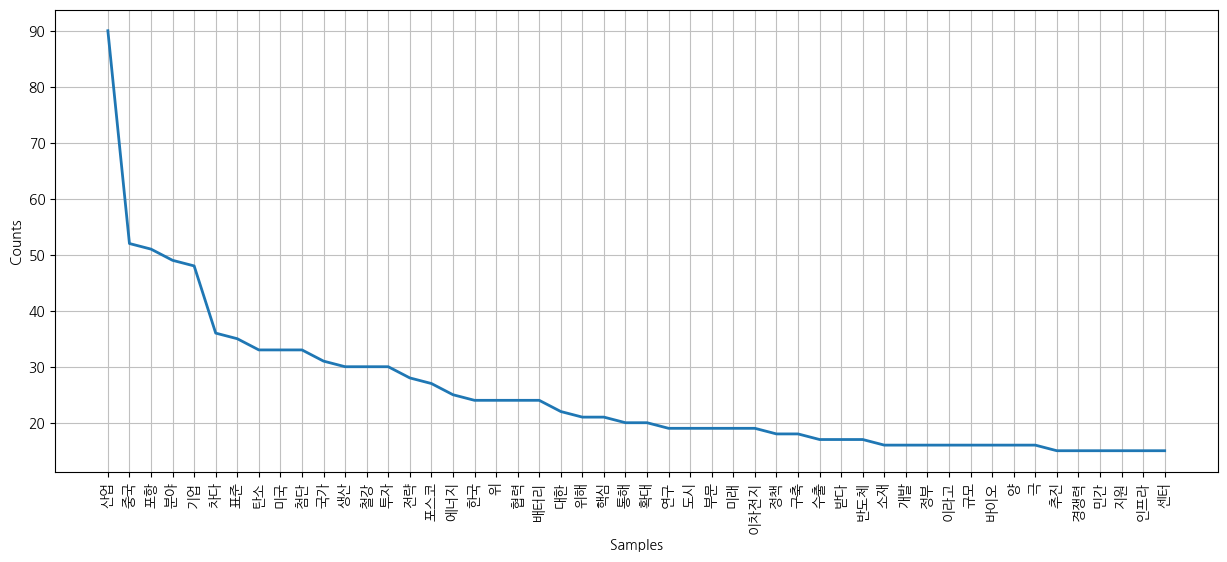

In [ ]:
tokens_ko = [each_word for each_word in tokens_ko
           if each_word not in stop_words]

ko = nltk.Text(tokens_ko)

# 그래프에서 한글 폰트가 깨질 경우 실행
# from matplotlib import font_manager, rc
# font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
# rc('font', family=font_name)

plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- WordCloud

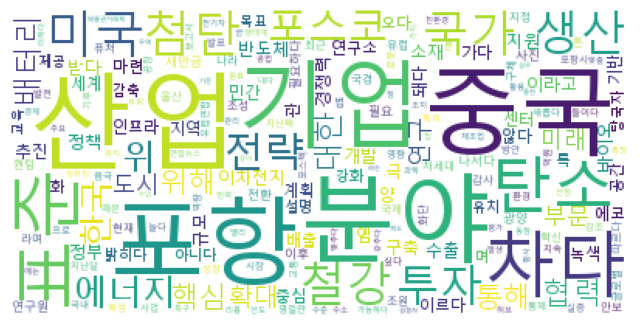

In [ ]:
data = ko.vocab().most_common(300)
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 3.2 산업별 월별 감성지수

### 철강산업 전망지수

- 일자별로 데이터프레임 정리

In [ ]:
# 철강산업_preprocess = pd.read_csv('철강산업_preprocess.csv',encoding='utf-8-sig')

In [ ]:
# #2023년 5월 뉴스
# 철강산업_202305 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('May 2023')].reset_index(drop=True)
# 철강산업_202305.to_csv('철강산업_202305.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2023년 4월 뉴스
# 철강산업_202304 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Apr 2023')].reset_index(drop=True)
# 철강산업_202304.to_csv('철강산업_202304.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2023년 3월 뉴스
# 철강산업_202303 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Mar 2023')].reset_index(drop=True)
# 철강산업_202303.to_csv('철강산업_202303.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2023년 2월 뉴스
# 철강산업_202302 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Feb')].reset_index(drop=True)
# 철강산업_202302.to_csv('철강산업_202302.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2023년 1월 뉴스
# 철강산업_202301 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Jan')].reset_index(drop=True)
# 철강산업_202301.to_csv('철강산업_202301.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 12월 뉴스
# 철강산업_202212 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Dec')].reset_index(drop=True)
# 철강산업_202212.to_csv('철강산업_202212.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 11월 뉴스
# 철강산업_202211 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Nov')].reset_index(drop=True)
# 철강산업_202211.to_csv('철강산업_202211.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 10월 뉴스
# 철강산업_202210 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Oct')].reset_index(drop=True)
# 철강산업_202210.to_csv('철강산업_202210.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 9월 뉴스
# 철강산업_202209 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Sep')].reset_index(drop=True)
# 철강산업_202209.to_csv('철강산업_202209.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 8월 뉴스
# 철강산업_202208 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Agu')].reset_index(drop=True)
# 철강산업_202208.to_csv('철강산업_202208.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 7월 뉴스
# 철강산업_202207 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Jul')].reset_index(drop=True)
# 철강산업_202207.to_csv('철강산업_202207.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 6월 뉴스
# 철강산업_202206 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('Jun')].reset_index(drop=True)
# 철강산업_202206.to_csv('철강산업_202206.csv', index=False, encoding='utf-8-sig')

In [ ]:
# #2022년 5월 뉴스
# 철강산업_202206 = 철강산업_preprocess[철강산업_preprocess['pub_date'].str.contains('May')].reset_index(drop=True)
# 철강산업_202206.to_csv('철강산업_202205.csv', index=False, encoding='utf-8-sig')

- 뉴스 본문 감성지수 추출

In [ ]:
#!pip install transformers
import pandas as pd
import numpy as np
import re
import os
from transformers import pipeline



*   철강 산업 월별 뉴스데이터 링크:
*   https://drive.google.com/drive/folders/1YQ6zU-zavVKyKqzrAL53hwSTc9eDwPcu



In [ ]:
class IndustryAnalysis3: #IndustryAnalysis3 클래스 정의

    def __init__(self, industry, time=''):
        # 클래스 생성자, industry와 time을 인스턴스 변수로 저장
        self.industry = str(industry) # 산업을 문자열로 변환하여 저장
        self.time = time # 시간 정보 저장

    def path(self):
        # 데이터 파일 경로를 반환하는 메서드
        if self.time == 'all':
            # time이 'all'이면 모든 파일 경로를 가져옴
            path = ['/content/drive/MyDrive/데이콘_신한ai/수집데이터/월별데이터/'+ i for i in os.listdir('/content/drive/MyDrive/데이콘_신한ai/수집데이터/월별데이터')]
            # 해당 디렉토리 내 파일들의 경로를 리스트로 저장
            path = path[::-1] # 역순으로 정렬
        else:
            # time이 'all'이 아니라면 특정 파일 경로로 저장
            path = [f'/content/drive/MyDrive/데이콘_신한ai/수집데이터/월별데이터/{self.industry}산업_{self.time}.csv']
            # industry와 time 정보를 사용하여 특정 파일 경로 생성
        return path # 파일 경로 리스트 반환


    def clean(self, path):
        # 데이터를 정리하는 메서드
        ind = pd.read_csv(path) # 주어진 경로의 CSV 파일을 읽음
        ind_cont = ind['content'] # 'content' 열의 데이터 가져옴
        clean_li = [] # 정리된 데이터를 저장할 메서드

        pattern = '[^0-9ㄱ-ㅎㅏ-ㅣ가-힣\s]+|\xa0|\t\t\t'
        # 정규식 패턴, 특수 문자 및 공백 문자 제거용(숫자, 문자가 아닌 것)
        
        for i in range(len(ind_cont)):
            # 모든 데이터에 대해 반복
            result = re.sub(pattern, '', ind_cont.iloc[i].replace('\n', ''))
            # 패턴에 해당하지 않는 문자를 제거하고, 줄바꿈 문자를 공백으로 대체하여 데이터 정리
            clean_li.append(result) # 정리된 데이터를 리스트에 추가
        
        return clean_li # 정리된 데이터 리스트 반환


    def piece_freq(self, con):
        # 데이터 조각 중에서 industry 빈도가 가장 높은 조각을 찾는 메서드
        pieces = [con[i*800:(i+1)*800] for i in range(int(len(con)/800)+1)]
        # 데이터를 800자씩 조각으로 나누어 리스트에 저장
        freq = [piece.count(self.industry) for piece in pieces]
        # 각 조각에서 industry의 등장 횟수를 계산하여 리스트에 저장
        idx = freq.index(max(freq)) # 가장 높은 빈도의 인덱스 찾기

        return pieces[idx] # 가장 높은 빈도의 조각 반환


    def score(self, all_contents):  # LABEL_0: 긍정, LABEL_1: 부정, LABEL_2: 중립
        # 주어진 내용들에 대해 감정 점수를 계산하는 메서드

        pipe = pipeline(model='FINDA-FIT/KLUE-ROBERTA_LARGE_FALSE_KOFINSA_FULL', return_all_scores = True)
        # 감정 분석을 위한 모델 파이프라인 생성
        res = 0 # 결과 변수 초기화
        for content in all_contents:
            # 주어진 내용에 대해 반복
            result = pipe(content)
            # 모델로 감성 분석 수행
            score_sum = result[0][0]['score'] - result[0][1]['score']
            # 긍정 점수와 부정 점수의 차이 계산
            res += score_sum # 차이를 결과 변수에 누적

        return res/len(all_contents) # 모든 내용에 대한 평균 감성 점수 반환


    def process(self): 
        # 전체 처리 과정을 수행하는 메서드
        month_list = self.path()
        # 파일 경로 리스트를 가져옴
        contents_allfiles_lili = []
        # 모든 내용을 저장할 리스트
        scorelist = []
        # 감정 점수를 저장할 리스트
        
        for month in month_list:
            # 각 파일에 대해 반복
            conts_month = self.clean(month)
            # 파일 내용 정리
            pieces_freq_month = [self.piece_freq(cont) for cont in conts_month]
            # 파일 내용을 작은 조각으로 나누고, 빈도가 가장 높은 조각 찾기
            contents_allfiles_lili.append(pieces_freq_month)
            # 각 파일의 작은 조각들으르 리스트에 저장

        for onemonth_conts in contents_allfiles_lili:
            # 각 파일의 작은 조각에 대해 반복
            scorelist.append(self.score(onemonth_conts))
            # 작은 조각들에 대해 감정 점수 계산하여 리스트에 저장
        
        return scorelist # 모든 파일에 대한 감정 점수 리스트 반환
  

In [ ]:
steel_2211 = IndustryAnalysis3('철강', 202211)
steel_all = IndustryAnalysis3('철강', 'all')
steel_all.process()  

- 철강산업 전망지수

In [ ]:
steel_index = [-0.10968061654835287,
 0.009143687107346275,
 -0.4637190233916044,
 -0.02623266540467739,
 -0.3111803074263864,
 0.4757307063003904,
 -0.14868782890530732,
 -0.11620132656904256,
 -0.04204485414084047,
 -0.02593067650284086,
 -0.06947903394839673,
 0.3879051092824265,
 0.4020381139448056]

<Axes: title={'center': '1-year future index for the steel industry'}, xlabel='Month', ylabel='future index'>

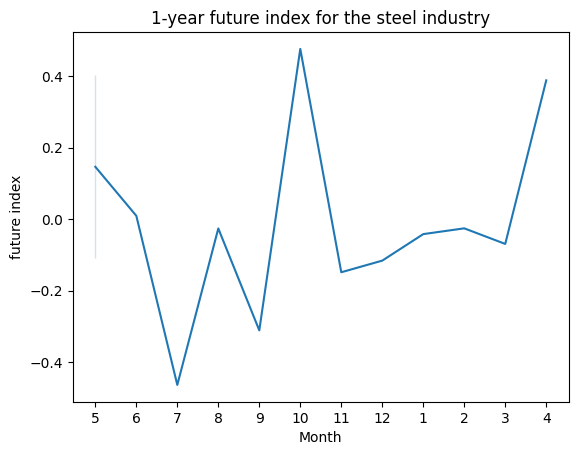

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# x축과 y축의 라벨을 설정합니다.
plt.xlabel('Month')
plt.ylabel('future index')

# 그래프의 제목을 설정합니다.
plt.title('1-year future index for the steel industry')
months = list(map(str,[5,6,7,8,9,10,11,12,1,2,3,4,5]))
df_index = pd.DataFrame({'months': months, 'index_months': steel_index})

sns.lineplot(steel_index, x=months, y=steel_index)

In [ ]:
df_index

,months,index_months
0,5,-10.97%
1,6,0.91%
2,7,-46.37%
3,8,-2.62%
4,9,-31.12%
5,10,47.57%
6,11,-14.87%
7,12,-11.62%
8,1,-4.20%
9,2,-2.59%


- 산업별 월별 산업지수

In [ ]:
import pandas as pd
sector_month_index = pd.DataFrame({
    'Date': 'May 2023',
    'Sector': ['철강','IT 서비스','해운사','선박','건설','전기','의복'],
    '산업지수': [0.9,0.6,0.4,0.1,-0.8,-0.3,-0.1]
})
sector_month_index

,Date,Sector,산업지수
0,May 2023,철강,0.9
1,May 2023,IT 서비스,0.6
2,May 2023,해운사,0.4
3,May 2023,선박,0.1
4,May 2023,건설,-0.8
5,May 2023,전기,-0.3
6,May 2023,의복,-0.1




```
# 코드로 형식 지정됨
```

### 4. 블랙리터만 모델을 활용한 다이렉트 인덱싱

In [ ]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pylab as plt
from numpy.linalg import inv
from pandas_datareader import data as web
!pip install finance-datareader
import FinanceDataReader as fdr
from scipy.optimize import minimize
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
krx=KRX_data.transpose()
krx.loc['code']=krx.columns
krx.columns = krx.loc['Name']

- 투자자가 코스피 종목 중 [삼성전자 LG에너지솔루션 LG화학 삼성SDI 현대차 기아 NAVER POSCO홀딩스 고려아연 현대제철] 을 선택했다고 가정한다.

In [ ]:
pick = ['삼성전자','LG에너지솔루션','LG화학','삼성SDI','현대차', '기아','NAVER', 'POSCO홀딩스','고려아연', '현대제철']



*   리벨런싱 주기 : 한달
*   산업전망지수 고려 섹터: 철강및금속
*   산업별 전망 반영 방향 : 긍정
*   임계값 긍정>0.4
*   초과수익률 부과 : 1%



In [ ]:
#자본비율
pick_cap=krx.loc['Marcap',['삼성전자','LG에너지솔루션','LG화학','삼성SDI','현대차', '기아','NAVER', 'POSCO홀딩스','고려아연', '현대제철']]
W_c=np.array(pick_cap/np.sum(pick_cap))

In [ ]:
#4월 코스피 수익률
kospi = fdr.DataReader('KS11',start='2023-4-1',end='2023-05-01')
kospi_ret = np.log(kospi['Close']/kospi['Close'].shift(1)).dropna()
kospi_mean=np.mean(kospi_ret)

In [ ]:
def get_price(companies):
    df=pd.DataFrame()
    for company in companies:
        df[company]= fdr.DataReader(company,start='2023-4-1',end='2023-05-01')['Close']
    return df
def get_return(companies,data):
    df1 = pd.DataFrame()
    for company in companies:
        df1[company+'return'] = np.log(data[company]/data[company].shift(1)).dropna()
    return df1

In [ ]:
a = krx.loc[['Code'],pick].values.tolist()
pick_code=np.reshape(a,(10)).tolist()

In [ ]:
# 종목별 수익률을 통한 초과수익률 계산
pick_close=get_price(pick_code)
pick_return=get_return(pick_code,pick_close)
exret=pick_return-kospi_mean

In [ ]:
# 한달 기준 수익률/공분산 계산
R = (1+pick_mean)**20-1
covars=exret.cov()
C = covars*20

#무위험 이자율은 가정상 1.5%로 결정
rf=0.015

mean=sum(R*W_c)
var = np.dot(np.dot(W_c,C),W_c)

#위험회피계수
lmbda = (mean-rf)/var

#균형초과수익률
pi = np.dot(np.dot(lmbda, C), W_c) 

In [ ]:
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        util = (mean - rf) / np.sqrt(var) 
        return 1 / util  

    n = len(R)
    W = np.ones([n]) / n  
    bnds = [(0., 1.) for i in range(n)]  
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
        raise BaseException(res.message)
    return res.x

In [ ]:
# 효율적 프런티어 계산
def solveFrontier(R, C, rf):
    def obj(W, R, C, r):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        penalty = 100 * abs(mean - r)             
        return var + penalty

    frontier_mean, frontier_var = [], []
    n = len(R) 

    for r in np.linspace(min(R), max(R), num=20):
        W = np.ones([n]) / n 
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})           
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            raise BaseException(res.message)       
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [ ]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):
    W = solveWeights(R, C, rf)
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    
    eff_mean, eff_var = solveFrontier(R, C, rf) 
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

- 균형기대수익률로 최적화

In [ ]:
#균형기대수익률로 최적화
opt = optimize_frontier(pi+rf, C, rf)

#블랙숄즈모델을 통해 역추산한 가중치
display(HTML('Implied Excess Equilibrium Returns'))
display(pd.DataFrame({'Weight': opt['weights']}, index=pick).T)

,삼성전자,LG에너지솔루션,LG화학,삼성SDI,현대차,기아,NAVER,POSCO홀딩스,고려아연,현대제철
Weight,49.39%,17.99%,6.59%,6.64%,5.04%,4.25%,4.31%,3.81%,1.40%,0.59%


- 산업전망지수 반영

In [ ]:
#다음달 감정지수의 예측값이 0.4보다 높을 경우 초과수익률 1% 반영
if steel_index[-1]>0.4:
  tf = (sector_list[pick]=='코스피 철강및금속')*1.
  P = np.array([tf.loc[0]])
  Q= np.array([0.01])

In [ ]:
#위험조정상수 
tau = 0.025

#투자자 전망의 불확실성 계산
omega = np.dot(np.dot(np.dot(tau,P),C),np.transpose(P))

In [ ]:
omega

array([[0.00138392]])

In [ ]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
bl1 = inv(np.dot(tau, C))
bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
bl3 = np.dot(inv(np.dot(tau, C)), pi)
bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
pi_adj = np.dot(inv(bl1 + bl2), (bl3 + bl4))

opt1 = optimize_frontier(pi_adj + rf, C, rf)

In [ ]:
#산업전망지수와 투자자의 결정을 반영한 투자비중
display(HTML('Implied returns with adjusted views'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=pick).T)

,삼성전자,LG에너지솔루션,LG화학,삼성SDI,현대차,기아,NAVER,POSCO홀딩스,고려아연,현대제철
Weight,43.92%,16.01%,5.86%,5.90%,4.48%,3.78%,3.83%,7.07%,4.93%,4.21%
